# Proteomics heatmaps

Notebook for visualizing proteomics heatmaps.

2020-12-11

## Initial boilerplate

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Python-dotenv could not parse statement starting at line 1


Standard variables loaded, you are good to go!


## 1. Loading data

Let's build the dataset to plot later & see how many significant proteins we have in each group:

In [2]:
import pandas as pd
import numpy as np

comparisons = ['NaCl-Control', 'KCl-Control']
summary_df = pd.DataFrame()
significant_df = pd.DataFrame(columns = ['logFC','FDR'])
for comparison in comparisons:
    file_name = join(INTERMEDIATE,f"Tables_edgeR_{comparison}_proteomics.tabular")
    new_df = pd.read_csv(file_name, index_col=0, sep="\t")
    
    # generate summary dataframe: 
    is_up = np.logical_and(new_df["FDR"] < 0.05, new_df["logFC"] > 0)
    is_down = np.logical_and(new_df["FDR"] < 0.05, new_df["logFC"] < 0)
    new_line = pd.DataFrame(index = [comparison], data = {"n_up":sum(is_up), "n_down":sum(is_down)})
    summary_df = summary_df.append(new_line)
    
    # build significant dataframe:
    for (idx, row) in new_df.iterrows():
        if row["FDR"] < 0.05:
            new_line = pd.DataFrame(index = [f"{idx}_{comparison}"], data = {"logFC":row["logFC"], "FDR":row["FDR"]})
            significant_df = significant_df.append(new_line)
                                                   
summary_df

,n_up,n_down
NaCl-Control,520,381
KCl-Control,626,543


In [3]:
significant_df

,logFC,FDR
Q6BVV1_NaCl-Control,17.698250,0.000120
B5RTM9_NaCl-Control,18.577251,0.000120
Q6BJ28_NaCl-Control,1.769768,0.000120
Q6BYM5_NaCl-Control,17.843282,0.000565
B5RUR2_NaCl-Control,17.067749,0.000565
...,...,...
Q6BV74_KCl-Control,0.393783,0.049812
Q6BSV9_KCl-Control,-1.129522,0.049812
Q6BM83_KCl-Control,-0.405233,0.049838
Q6BKI3_KCl-Control,0.487619,0.049888


## 2. Heatmaps

        NaCl-Control  KCl-Control
Q6BJ28      1.769768     1.932111
Q6BVV1     17.698250    18.171436
B5RTM9     18.577251    18.238557
Q6BPB3      4.868554     6.357677
Q6BIP1     -1.946621    -3.197082
Q6BVD0      2.067354     2.749157
Q6BYM5     17.843282    17.495369
Q6BZJ8      1.127444     1.404499
Q6BTI5     18.770135    19.746651
B5RUR2     17.067749    16.290620
Q6BRS3      2.149631     0.000000
Q6BV99     -2.608946    -2.795555
B5RUI5      1.214504     1.264378
Q6BKX0      1.534260     1.601703
Q6BS18      1.754464     2.423286
Q6BV08     15.407545    16.855297
Q6BZC7      1.317618     1.556673
Q6BQA7     -1.291086    -1.935685
Q6BH90      1.131206     1.047621
Q6BLV6      1.677041     2.099513
Q6BY85      1.383615     1.561734
B5RUA9      1.143646     1.213192
Q6BPR7      1.269636     2.048351
Q6BSF3     15.086912    16.652458
Q6BX28      1.081996     1.100961
Q6BQH6      3.172001     3.903305
Q6BH50      1.536271     2.339665
B5RTQ7      2.268206     2.236255
B5RT72      3.

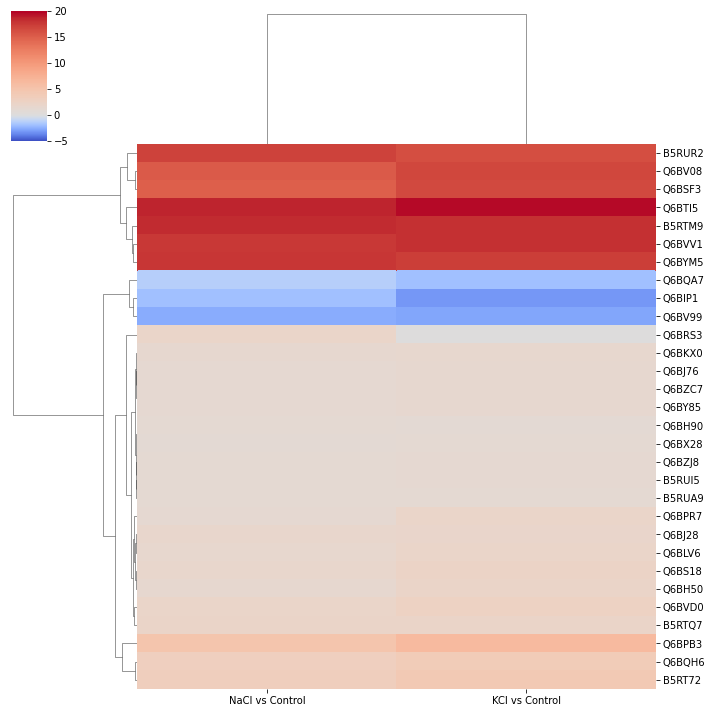

In [9]:
import seaborn as sns
from matplotlib import colors
from matplotlib import pyplot as plt

def reduce_df(df, df_size):
    # Sort and filter the most significant ones:
    df_filtered = df.sort_values(by = 'FDR').iloc[:df_size,]
    
    # Create dataframe with only fold changes:
    df_reduced = pd.DataFrame(columns = comparisons)
    for (idx, row) in df_filtered.iterrows():
        new_idx = idx.split('_')[0]
        col = idx.split('_')[1]
        if new_idx not in new_df.index:
            df_reduced.append(pd.DataFrame(index = [new_idx]))
        df_reduced.loc[new_idx,col] = df.loc[idx,'logFC']
        if col == 'KCl-Control':
            idx_2 = idx.replace('KCl','NaCl')
        else:
            idx_2 = idx.replace('NaCl','KCl')
        col_2 = idx_2.split('_')[1]
        try:
            df_reduced.loc[new_idx,col_2] = df.loc[idx_2,'logFC']
        except:
            pass
    
    # Fill up with NA:
    df_reduced = df_reduced.fillna(0)
    print(df_reduced)
    return df_reduced

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def heatmap(df, df_size, df_name):
    # pre-process:
    df = reduce_df(df, df_size)
    # plot:
    df.columns = [name.replace("-"," vs ") for name in df.columns.tolist()]
    if df.to_numpy().min() >= 0:
        colormap = "Reds"
    else:
        colormap = "coolwarm"  
    sns.clustermap(df, cmap=colormap, norm=MidpointNormalize(midpoint=0, vmin=-5, vmax=+20))
    plt.savefig(join(FIGURES,f'{df_name}.eps'), format='eps')
    plt.savefig(join(FIGURES,f'{df_name}.pdf'), format='pdf')
    
heatmap(significant_df, 44, 'heatmap-proteomics')